In [1]:
import pandas as pd
import numpy as np
import json
import pandas as pd
import re
from rdkit import Chem
from rdkit.Chem import AllChem
from collections import Counter,defaultdict
from ast import literal_eval
import cobra
from cobra import Metabolite,Reaction,Gene

import sys
sys.path.append('../retrosynthesis/')
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as mpatches
from common import *
# from check_newinfo_getyeast8U import *

In [2]:
### input
yeast870_path =  '../../Data/model/yeast-GEM.yml'
yeast8U_path = '../../Data/model/Yeast-MetaTwin.yml'
sce_gene_clean_ec = '../../Results/ECnumber_prediction/Saccharomyces_cerevisiae_maxsep.csv'
DeepEC_path = '../../Results/ECnumber_prediction/Sce_DeepECv2.txt'
sce_uniprotkb_gene_file = '../../Data/uniprot/uniprotkb_organism_id_559292_2023_11_08.tsv'

### output
figs12_path = '../../Results/Figures/figs12.pdf'

In [3]:
uniprot_data = pd.read_csv(sce_uniprotkb_gene_file,sep='\t')
uniprot_data = uniprot_data.fillna('')
print(uniprot_data.shape)
uniprot_data.head()

(6735, 5)


,Entry,Organism,Gene Names,Protein names,EC number
0,A0A0B7P3V8,Saccharomyces cerevisiae (strain ATCC 204508 /...,TY4B-P YPLCTy4-1 POL YPL060C-A,Transposon Ty4-P Gag-Pol polyprotein (TY4A-TY4...,2.7.7.49; 2.7.7.7; 3.1.26.4; 3.4.23.-
1,D6VTK4,Saccharomyces cerevisiae (strain ATCC 204508 /...,STE2 YFL026W,Pheromone alpha factor receptor,
2,O13297,Saccharomyces cerevisiae (strain ATCC 204508 /...,CET1 YPL228W P1433,mRNA-capping enzyme subunit beta (EC 3.6.1.74)...,3.6.1.74
3,O13329,Saccharomyces cerevisiae (strain ATCC 204508 /...,FOB1 HRM1 YDR110W YD9727.06,DNA replication fork-blocking protein FOB1,
4,O13516,Saccharomyces cerevisiae (strain ATCC 204508 /...,RPS9A RPS13A YS11A YPL081W,Small ribosomal subunit protein uS4A (40S ribo...,


In [4]:
uniprot_data_ec_frequence = {}
for index,row in uniprot_data.iterrows():
    ec_lst = row['EC number'].split('; ')
    # print(ec_lst)
    ec_lst = ['.'.join(x.split('.')[0:3]) for x in ec_lst]
    # print(ec_lst)
    ec_lst = [x for x in ec_lst if x != '' and '-' not in x]
    # print(ec_lst)

    for i in ec_lst:
        if i not in uniprot_data_ec_frequence.keys():
            uniprot_data_ec_frequence[i]=0
        else:
            uniprot_data_ec_frequence[i]+=1
len(uniprot_data_ec_frequence)

def get_uniprot_ec_frequency(ec,uniprot_data_ec_frequence):
    if ec in uniprot_data_ec_frequence.keys():
        return uniprot_data_ec_frequence[ec]
    else:
        return 0

In [5]:
yeast8 = cobra.io.load_yaml_model(yeast870_path)
yeast8.summary()

yeast8U = cobra.io.load_yaml_model(yeast8U_path)
yeast8U.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
s_0420,r_1654,0.6402,0,0.00%
s_0565,r_1714,1,6,100.00%
s_0796,r_1832,0.04529,0,0.00%
s_0925,r_1861,0.005913,0,0.00%
s_1277,r_1992,1.997,0,0.00%
s_1324,r_2005,0.04482,0,0.00%
s_1374,r_2020,0.000325,0,0.00%
s_1438,r_2049,0.0003555,0,0.00%
s_1468,r_2060,0.001791,0,0.00%
s_4200,r_4593,0.0001155,0,0.00%


## gene frequency

In [6]:


# Process reactions for yeast8U
yeast8U_gene_frequece_dict = process_reactions(yeast8U.reactions)

# Process reactions for yeast8
yeast8_gene_frequece_dict = process_reactions(yeast8.reactions)

# Output the frequency dictionaries
# print(yeast8U_gene_frequece_dict)
# print(yeast8_gene_frequece_dict)

2057
1163


## gene2ec

In [7]:
clean_gene2ec_dict = get_gene2ec_dict_clean(sce_gene_clean_ec)
clean_gene2ec_dict

{'YDL204W': ['5.3.99'],
 'YNL167C': ['2.3.2'],
 'YJL068C': ['3.1.2'],
 'YBL005W': ['2.3.1'],
 'YFR013W': ['2.3.1'],
 'YLR037C': ['1.12.99'],
 'YHR077C': ['5.6.2'],
 'YGR294W': ['3.2.2'],
 'YGR233C': ['4.2.3'],
 'YOL162W': ['1.14.15'],
 'YLR001C': ['2.7.6'],
 'YJL052C-A': ['3.5.1'],
 'YPL240C': ['3.6.4'],
 'YER159C-A': ['3.4.21'],
 'YGR245C': ['2.1.1'],
 'YPL036W': ['7.1.2'],
 'YGL249W': ['2.3.1'],
 'YDL166C': ['2.7.4'],
 'YDR289C': ['3.4.21'],
 'YDR170C': ['2.3.2'],
 'YBR281C': ['3.4.13'],
 'YDR246W-A': ['3.4.22'],
 'YCR095C': ['3.1.3'],
 'YLR226W': ['2.3.1'],
 'YBR180W': ['2.4.1', '3.4.16', '3.1.1'],
 'YKL005C': ['2.1.1'],
 'YDR063W': ['3.1.3'],
 'YCR089W': ['2.4.1'],
 'YPL056C': ['3.2.1'],
 'YGR003W': ['5.6.2'],
 'YGL198W': ['2.4.1'],
 'YDR260C': ['1.11.1'],
 'YOR093C': ['4.2.3'],
 'YIL134C-A': ['3.4.24'],
 'YDR051C': ['3.1.3', '2.7.1'],
 'YDR177W': ['2.3.2'],
 'YDR522C': ['1.6.5'],
 'YJR007W': ['3.1.13'],
 'YDR497C': ['2.1.1'],
 'YBR163W': ['3.1.12'],
 'YLL032C': ['2.7.7'],
 'YEL054

In [8]:


# Process reactions for yeast8U
yeast8U_ec_frequency_dict = process_reactions_to_ec_frequency(yeast8U.reactions, clean_gene2ec_dict)

# Process reactions for yeast8
yeast8_ec_frequency_dict = process_reactions_to_ec_frequency(yeast8.reactions, clean_gene2ec_dict)

# Output the EC frequency dictionaries
# print(yeast8U_ec_frequency_dict)
# print(yeast8_ec_frequency_dict)

yeast8U_yeast8_ec_frequency = {'EC':[],
                               'yeast8':[],
                               'yeast8U':[]}
for k,v in yeast8U_ec_frequency_dict.items():
    yeast8U_yeast8_ec_frequency['EC'].append(k)
    yeast8U_yeast8_ec_frequency['yeast8U'].append(v)
    if k in yeast8_ec_frequency_dict.keys():
        yeast8U_yeast8_ec_frequency['yeast8'].append(yeast8_ec_frequency_dict[k])
    else:
        yeast8U_yeast8_ec_frequency['yeast8'].append(0)

yeast8U_yeast8_ec_frequency_df = pd.DataFrame(yeast8U_yeast8_ec_frequency)
yeast8U_yeast8_ec_frequency_df['ratio'] = yeast8U_yeast8_ec_frequency_df.apply(
    lambda row: row['yeast8U'] / row['yeast8'] if row['yeast8'] != 0 else 0,
    axis=1
)
yeast8U_yeast8_ec_frequency_df.head(10)

,EC,yeast8,yeast8U,ratio
0,1.8.99,0,619,0.000000
1,1.1.1,158,454,2.873418
2,1.1.99,11,433,39.363636
3,1.14.13,6,396,66.000000
4,1.14.11,2,390,195.000000
5,1.11.2,1,263,263.000000
6,1.97.1,0,258,0.000000
7,1.11.1,11,228,20.727273
8,1.14.14,3,224,74.666667
9,1.3.1,27,201,7.444444


In [9]:
yeast8U_yeast8_ec_frequency_df['uniprot'] = yeast8U_yeast8_ec_frequency_df['EC'].apply(lambda x:get_uniprot_ec_frequency(x,uniprot_data_ec_frequence))
yeast8U_yeast8_ec_frequency_df

,EC,yeast8,yeast8U,ratio,uniprot
0,1.8.99,0,619,0.000000,0
1,1.1.1,158,454,2.873418,85
2,1.1.99,11,433,39.363636,1
3,1.14.13,6,396,66.000000,2
4,1.14.11,2,390,195.000000,4
...,...,...,...,...,...
149,7.5.2,3,113,37.666667,0
150,7.2.2,16,100,6.250000,9
151,7.2.1,6,91,15.166667,0
152,7.1.2,5,5,1.000000,3


In [10]:
corr_score_frequency = yeast8U_yeast8_ec_frequency_df["uniprot"].corr(yeast8U_yeast8_ec_frequency_df["yeast8"])
corr_score_frequency

0.5520119064676341

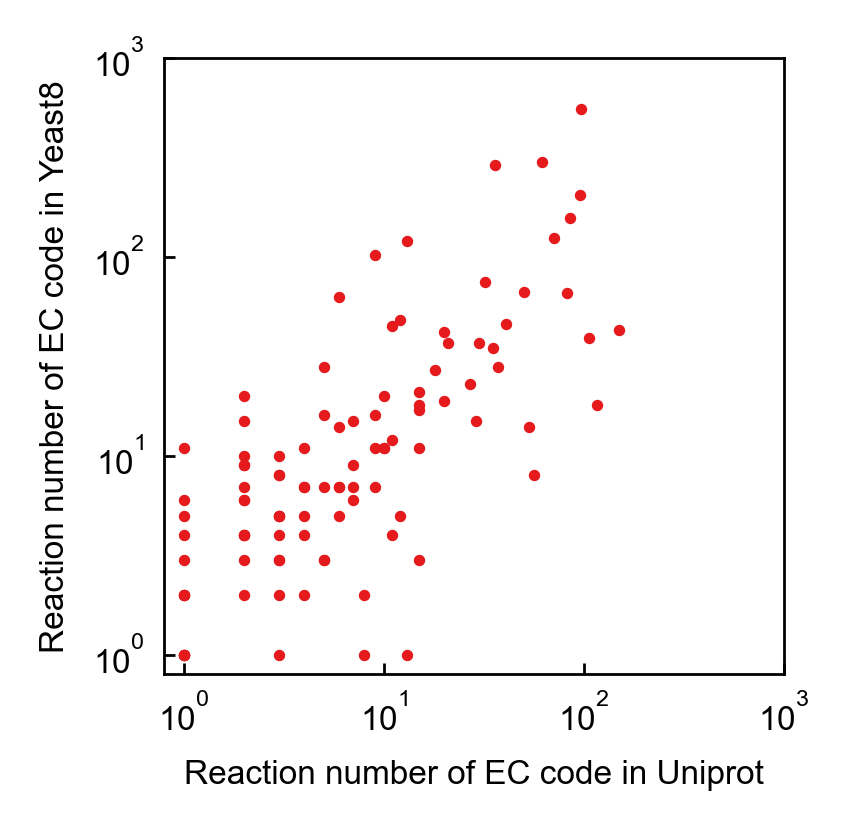

In [11]:
# Setting General Parameters
plt.figure(figsize=(2, 2), dpi=400)
plt.rcParams.update({'font.size': 6})
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

# Setting Axis Styles
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.gca().spines['top'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0.5)

# Adjusting the size of scatter points (s parameter) and using normalized 'score'
plt.scatter(yeast8U_yeast8_ec_frequency_df['uniprot'], yeast8U_yeast8_ec_frequency_df['yeast8'], 
            s=1.1,  # Size of the points
            c='#e41a1c'  # Color of the points
           )

# Setting X-axis Labels
plt.xlabel('Reaction number of EC code in Uniprot', fontsize=6)
plt.ylabel('Reaction number of EC code in Yeast8', fontsize=6)

# Set x-axis to logarithmic scale
# plt.gca().set_xscale('log')

# Set x-axis range to [0.8, 1000]
plt.xlim(0.8, 1000)
plt.ylim(0.8, 1000)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.minorticks_off()  # Hide minor ticks

plt.tick_params(axis='both', direction='in', width=0.5, which='both', length=2)

# Adding Legend
# plt.text(1575*0.65, 1.03, r'$\mathit{N} = 1296$', fontsize=7, ha='left', va='top')
# plt.text(1575*0.65, 0.95, r'$\mathit{r} = -0.04$', fontsize=7, ha='left', va='top')

# Save the figure to a file
# plt.savefig('../Figure-new/fig6-b.pdf', dpi=400, bbox_inches='tight')
plt.show()

In [12]:
yeast8U_yeast8_ec_frequency_df.shape

(154, 5)

## According to the first position of ec

In [13]:
# extract the first digit of EC number
yeast8U_yeast8_ec_frequency_df['EC_first_digit'] = yeast8U_yeast8_ec_frequency_df['EC'].str.split('.').str[0]
# group by the first digit of EC number and sum
yeast8U_yeast8_ec_frequency_df_first = yeast8U_yeast8_ec_frequency_df.groupby('EC_first_digit')[['yeast8', 'yeast8U','uniprot']].sum().reset_index()
yeast8U_yeast8_ec_frequency_df_first['ratio'] = yeast8U_yeast8_ec_frequency_df_first.apply(
    lambda row: row['yeast8U'] / row['yeast8'] if row['yeast8'] != 0 else 0,
    axis=1
)
yeast8U_yeast8_ec_frequency_df_first['ratio2'] = yeast8U_yeast8_ec_frequency_df_first.apply(
    lambda row: row['yeast8U'] / row['uniprot'] if row['uniprot'] != 0 else 0,
    axis=1
)
yeast8U_yeast8_ec_frequency_df_first

,EC_first_digit,yeast8,yeast8U,uniprot,ratio,ratio2
0,1,424,4721,212,11.134434,22.268868
1,2,1477,9953,781,6.738659,12.743918
2,3,909,8367,615,9.204620,13.604878
3,4,181,2063,102,11.397790,20.225490
4,5,60,1395,54,23.250000,25.833333
5,6,130,296,87,2.276923,3.402299
6,7,110,1477,23,13.427273,64.217391


In [14]:
yeast8U_yeast8_ec_frequency_df_first['ratio/1'] = yeast8U_yeast8_ec_frequency_df_first['yeast8']/yeast8U_yeast8_ec_frequency_df_first['yeast8U']
yeast8U_yeast8_ec_frequency_df_first['ratio2/1'] = yeast8U_yeast8_ec_frequency_df_first['uniprot']/yeast8U_yeast8_ec_frequency_df_first['yeast8U']
yeast8U_yeast8_ec_frequency_df_first['ratio/1'] = yeast8U_yeast8_ec_frequency_df_first['ratio/1'].apply(lambda x: f"{x * 100:.1f}%")
yeast8U_yeast8_ec_frequency_df_first['ratio2/1'] = yeast8U_yeast8_ec_frequency_df_first['ratio2/1'].apply(lambda x: f"{x * 100:.1f}%")

yeast8U_yeast8_ec_frequency_df_first

,EC_first_digit,yeast8,yeast8U,uniprot,ratio,ratio2,ratio/1,ratio2/1
0,1,424,4721,212,11.134434,22.268868,9.0%,4.5%
1,2,1477,9953,781,6.738659,12.743918,14.8%,7.8%
2,3,909,8367,615,9.204620,13.604878,10.9%,7.4%
3,4,181,2063,102,11.397790,20.225490,8.8%,4.9%
4,5,60,1395,54,23.250000,25.833333,4.3%,3.9%
5,6,130,296,87,2.276923,3.402299,43.9%,29.4%
6,7,110,1477,23,13.427273,64.217391,7.4%,1.6%


In [15]:
print(len(yeast8U_yeast8_ec_frequency_df[yeast8U_yeast8_ec_frequency_df['EC_first_digit']=='1']))
print(len(yeast8U_yeast8_ec_frequency_df[yeast8U_yeast8_ec_frequency_df['EC_first_digit']=='2']))
print(len(yeast8U_yeast8_ec_frequency_df[yeast8U_yeast8_ec_frequency_df['EC_first_digit']=='3']))
print(len(yeast8U_yeast8_ec_frequency_df[yeast8U_yeast8_ec_frequency_df['EC_first_digit']=='4']))
print(len(yeast8U_yeast8_ec_frequency_df[yeast8U_yeast8_ec_frequency_df['EC_first_digit']=='5']))
print(len(yeast8U_yeast8_ec_frequency_df[yeast8U_yeast8_ec_frequency_df['EC_first_digit']=='6']))
print(len(yeast8U_yeast8_ec_frequency_df[yeast8U_yeast8_ec_frequency_df['EC_first_digit']=='7']))

53
25
33
15
13
8
7


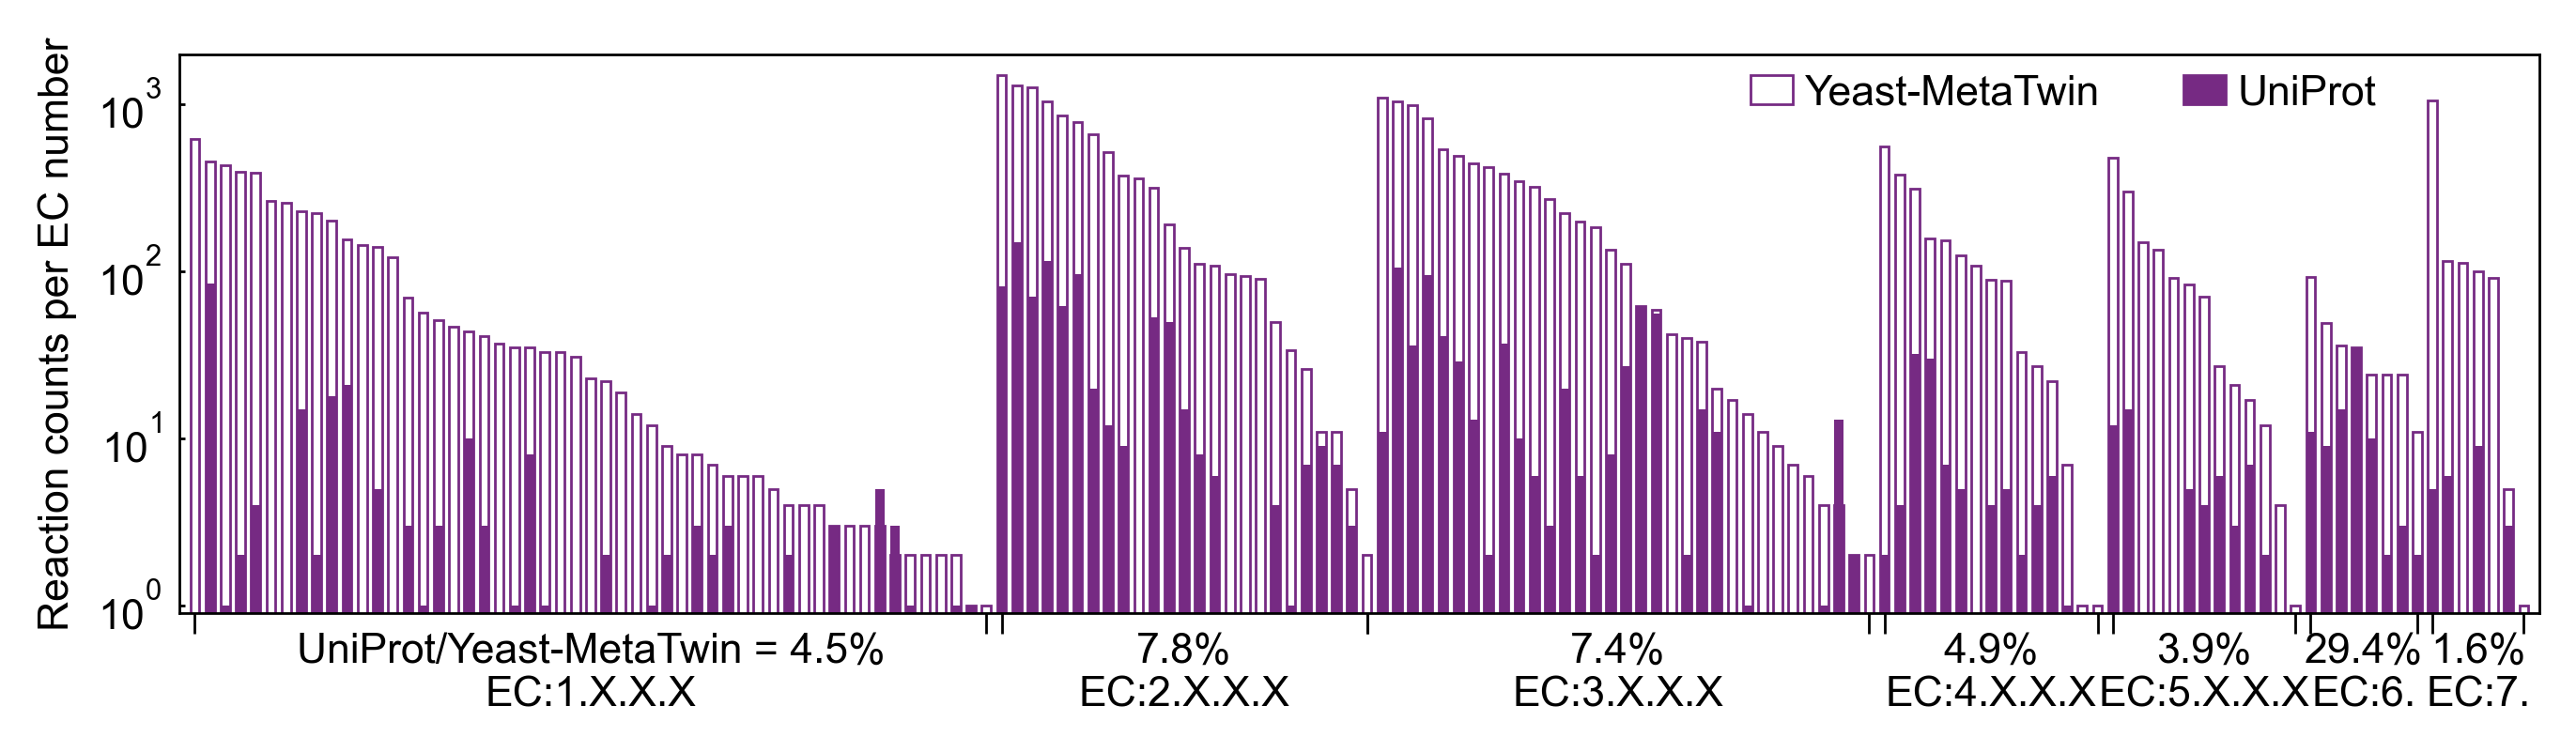

In [16]:
ratio_lst  = yeast8U_yeast8_ec_frequency_df_first['ratio2/1'].tolist()

# Setting General Parameters
plt.figure(figsize=(6.9, 2), dpi=400)
plt.rcParams.update({'font.size': 8})
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

# Setting Axis Styles
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(0.5)

# Plotting Stacked Bar Chart
bar_width = 0.6
index = np.arange(len(yeast8U_yeast8_ec_frequency_df['EC']))

colors = ['#762a83'] * 7
sections = [(0, 53), (53, 78), (78, 111), (111, 126), (126, 139), (139, 147), (147, 154)]

for i, (start, end) in enumerate(sections):
    plt.bar(index[start:end], yeast8U_yeast8_ec_frequency_df['yeast8U'][start:end], 
            width=bar_width, color='white', edgecolor=colors[i], linewidth=0.5)
    plt.bar(index[start:end], yeast8U_yeast8_ec_frequency_df['uniprot'][start:end], 
            width=bar_width, color=colors[i])

# Setting X-axis Labels
plt.yticks(fontsize=8)

# Setting X-axis Tick Positions and Labels
specific_ticks = [0, 52, 53, 77, 77, 110, 111, 125, 126, 138, 139, 146, 147, 153]
plt.xticks(specific_ticks, [''] * len(specific_ticks))

specific_ticks2 = [26, 65, 93.5, 118, 132, 142.5, 150]
specific_labels2 = [f'UniProt/Yeast-MetaTwin = {ratio_lst[0]}\nEC:1.X.X.X', f'{ratio_lst[1]}\nEC:2.X.X.X', f'{ratio_lst[2]}\nEC:3.X.X.X', f'{ratio_lst[3]}\nEC:4.X.X.X', 
                    f'{ratio_lst[4]}\nEC:5.X.X.X', f'{ratio_lst[5]}\nEC:6.', f'{ratio_lst[6]}\nEC:7.']
for tick, label in zip(specific_ticks2, specific_labels2):
    plt.text(tick, 0.7, label, ha='center', va='top', fontsize=8, rotation=0)

# Setting Axis Parameters
plt.tick_params(axis='y', direction='in', width=0.5, which='both', length=1)
plt.tick_params(axis='x', which='both', width=0.5, length=4, pad=1)

plt.xlim(-1, 154)
plt.ylim(0.9, 2000)
plt.yscale('log')
plt.minorticks_off()

plt.ylabel('Reaction counts per EC number', fontsize=8)

# Setting Legend
custom_patch1 = mpatches.Patch(facecolor='white', edgecolor='#762a83', linewidth=0.5, label='Yeast-MetaTwin')
custom_patch2 = mpatches.Patch(facecolor='#762a83', edgecolor='#762a83', linewidth=0.5, label='UniProt')

# Get current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Insert custom legend entries into handles and labels
handles.insert(0, custom_patch1)
handles.insert(1, custom_patch2)

# Create Legend
plt.legend(handles=handles, frameon=False, fontsize=8, loc='center left', 
           bbox_to_anchor=(0.65, 0.93), ncol=2, labelspacing=0.5, handletextpad=0.3, handlelength=1)

plt.tight_layout()
plt.savefig(figs12_path, dpi=400, bbox_inches='tight')
plt.show()